# New CTrader Indices Validation


#### Report Date : 11 January 2024

## Introduction

Due to delay-based exploits at the release of CTrader, new variations of 1s Volatility and Crash/Boom Indices are to be released in CTrader only, while the old indices should be removed from the new platform. The parameters of the upcoming indices are as below:

### <u>Volatility Indices</u>

|New Indices|Interest rate|Dividend Rate|Volatility|Pip Size|Starting Spot|Raw Spread|
|:---------:|:-----------:|:-----------:|:--------:|:------:|:-----------:|:--------:|
|Volatility 15 (1s)|0|0|0.15|0.001|10,000|0.00378%|
|Volatility 30 (1s)|0|0|0.3|0.001|10,000|0.00755%|
|Volatility 90 (1s)|0|0|0.9|0.001|10,000|0.0227%|

### <u>Crash/Boom Indices</u>

|New Indices|Jump Probability*|MDT|MUT|Pip Size|Starting Spot|Raw Spread|
|:---------:|:---------------:|:-:|:-:|:------:|:-----------:|:--------:|
|Crash 600|1/600 ≈ 0.00166666666|-5.619|0.00937373|0.001|10,000|0.00134%|
|Boom 600|1/600 ≈ 0.00166666666|-0.00938755|5.619|0.001|10,000|0.00134%|
|Crash 900|1/900 ≈ 0.00111111111|-5.619|0.00624569|0.001|10,000|0.00111%|
|Boom 900|1/900 ≈ 0.00111111111|-0.00625489|5.619|0.001|10,000|0.00111%|

\* Note that in production, Crash Boom Indices' probabilities are defined using `up_probability`. Counterintuitively, in the current implementation, `up_probability` represents the probability of going down. This is a minor issue, but can cause confusion in the future.

### Data
The data in the following sections is taken from 20 Dec 2023 until 27 Dec 2023, approximately a week of data. The new indices were initialized for CT-UAT testing on 19 Dec 2023, but a FIX feed issue prevented new ticks from being created until it was fixed on 20 Dec 2023. 

In [1]:
import numpy as np
from scipy.stats import norm, skew, kurtosis
from scipy.optimize import fsolve
from math import pi, erf, exp, log
import plotly.express as px
import matplotlib.pyplot as plt
import pandas as pd
from utils import read_csv_feeddb
import re



## Summary

The findings are summarized as below.

### <u>Volatility Indices</u>

1. The moments are within reasonable bounds around the expected values. In particular, the volatilities are correct up to 0.1% error.
2. The moments converge within 2-4 days.
3. The distributions appear to be normal, with further confirmation as skewness and excess kurtosis are close to 0.
4. The Metabase spread isn't as expected, there is rounding (to 2 d.p) on the raw half-spread in the production code. The dealing team has also set a 0.01% markup on CTrader (relative to spot).

In [194]:
for vol in VOL: 
    table = pd.DataFrame(index=['Theoretical', 'Feed', 'Relative Error (%)'], columns=['Volatility (%)'])
    table.loc['Theoretical','Volatility (%)'] = vol_expected.loc[vol, 'vol'] * 100
    table.loc['Feed','Volatility (%)'] = vol_df.loc[vol,'vol'] * 100
    table.loc['Relative Error (%)','Volatility (%)'] = (table.loc['Theoretical','Volatility (%)'] - table.loc['Feed','Volatility (%)']) / table.loc['Theoretical','Volatility (%)'] * 100
    table = table.style.set_caption(vol).format(precision=2)
    display(table)

,Volatility (%)
Theoretical,15.00
Feed,15.00
Relative Error (%),0.00


,Volatility (%)
Theoretical,30.00
Feed,29.99
Relative Error (%),0.03


,Volatility (%)
Theoretical,90.00
Feed,89.96
Relative Error (%),0.05


### <u>Crash/Boom Indices</u>

1. The recovered parameters and the volatilities are within reasonable bounds of the simulated values
2. The moments and parameters tend to converge within 2-4 days.
3. The step/jump distributions are folded normal.
4. The Metabase spread is as expected. The dealing team has also set a 0.01% markup on CTrader (relative to spot).
5. A leverage of 1:400 (similar to existing CB indices) results in a Negative Balance Adjustment per Total Trades rate between 0.004% to 0.0045%.

In [223]:
theoretical = {'CRASH600' : {
    'Frequency of Jumps (%)' : 0.16667,
    'Size of Jumps (%)' : 0.0999853, 
    'Volatility (%)' : 27.88
},'CRASH900' : {
    'Frequency of Jumps (%)' : 0.11111,
    'Size of Jumps (%)' : 0.0997855, 
    'Volatility (%)' : 22.765339
},
'BOOM600' : {
    'Frequency of Jumps (%)' : 0.16667,
    'Size of Jumps (%)' : 0.100132,
    'Volatility (%)' : 27.8897
},
'BOOM900' : {
    'Frequency of Jumps (%)' : 0.11111,
    'Size of Jumps (%)' : 0.1001325,
    'Volatility (%)' : 22.8172
}}


for cb in CB: 
    table = pd.DataFrame(index=['Theoretical', 'Feed', 'Relative Error (%)'], columns=['Frequency of Jumps (%)', 'Size of Jumps (%)', 'Volatility (%)'])
    table.loc['Theoretical','Frequency of Jumps (%)'] = theoretical[cb]['Frequency of Jumps (%)']
    table.loc['Theoretical','Size of Jumps (%)'] = theoretical[cb]['Size of Jumps (%)']
    table.loc['Theoretical','Volatility (%)'] = theoretical[cb]['Volatility (%)']

    table.loc['Feed','Frequency of Jumps (%)'] = jump_probabilities.loc[cb, 'Empirical Jump Probability'] * 100
    table.loc['Feed','Size of Jumps (%)'] = np.abs(jump_factors.loc[cb, 'Empirical Jump Size (%)'])
    table.loc['Feed','Volatility (%)'] = cb_df.loc[cb,'vol'] * 100
    
    table.loc['Relative Error (%)','Frequency of Jumps (%)'] = (table.loc['Theoretical','Frequency of Jumps (%)'] - table.loc['Feed','Frequency of Jumps (%)']) / table.loc['Theoretical','Frequency of Jumps (%)'] * 100
    table.loc['Relative Error (%)','Size of Jumps (%)'] = (table.loc['Theoretical','Size of Jumps (%)'] - table.loc['Feed','Size of Jumps (%)']) / table.loc['Theoretical','Size of Jumps (%)'] * 100
    table.loc['Relative Error (%)','Volatility (%)'] = (table.loc['Theoretical','Volatility (%)'] - table.loc['Feed','Volatility (%)']) / table.loc['Theoretical','Volatility (%)'] * 100
    table = table.style. set_caption(cb)
    display(table)

,Frequency of Jumps (%),Size of Jumps (%),Volatility (%)
Theoretical,0.166670,0.099985,27.880000
Feed,0.155752,0.100881,26.993745
Relative Error (%),6.550674,-0.895546,3.178819


,Frequency of Jumps (%),Size of Jumps (%),Volatility (%)
Theoretical,0.111110,0.099785,22.765339
Feed,0.113078,0.098135,22.663997
Relative Error (%),-1.771539,1.654004,0.445160


,Frequency of Jumps (%),Size of Jumps (%),Volatility (%)
Theoretical,0.166670,0.100132,27.889700
Feed,0.165761,0.101432,28.164462
Relative Error (%),0.545553,-1.298288,-0.985174


,Frequency of Jumps (%),Size of Jumps (%),Volatility (%)
Theoretical,0.111110,0.100132,22.817200
Feed,0.108319,0.096454,21.913187
Relative Error (%),2.512023,3.673521,3.961982


## Conclusion
The new CTrader indices are behaving as expected in terms of spot dynamics. The spreads, however, differ from the expected values due to production implementation & CTrader limitations.

# Validation Results

In [196]:
pd.set_option("display.precision", 10)

DT = 1/(365*86400)

# Moment-generating function for the folded normal distribution with loc=mu and scale=sigma, default at (1,1)
def MGF_folded(t, mu=1, sigma=1):
    return np.exp((sigma * t)**2 / 2 + mu * t) * norm.cdf(mu / sigma + sigma * t) \
           + np.exp((sigma * t)**2 / 2 - mu * t) * norm.cdf(-mu / sigma + sigma * t)

# Mean for the folded normal distribution with loc=mu and scale=sigma, default at (1,1)
def mu_folded(mu = 1, sigma = 1):
    return sigma*np.sqrt(2/pi)*exp(-mu**2/(2*sigma**2)) + mu * erf(mu/np.sqrt(2*sigma**2))

# Crash: requires probability of crash and relative difference of crashed price w.r.t previous spot
# Returns hash of MDT and MUT and formula MUT and error
def crash_get_mean_jumps(p_down = 0.001, diff_percent = 0.001, MDT = None):
    # Parameters
    p_up = 1 - p_down
    mu = 1
    sigma = 1
    
    
    # Mean of folded normal with parameters mu & sigma
    mu_Y = mu_folded()

    # MDT can be calculated using diff_percent only (Needs review & verification)
    if MDT is None:
        MDT = log(1-diff_percent)/np.sqrt(DT)
        
    # Solve using t2 to get t1 to ensure E(St/S{t-1}) = 1
    t2 = MDT*np.sqrt(DT)/mu_Y
    factor = lambda t: MGF_folded(t, mu, sigma)
    
    f = lambda x: 1 - p_down*factor(t2) - p_up*factor(x)
    z = fsolve(f,0)[0]

    # Final result
    MUT = z/np.sqrt(DT)*mu_Y
    # Given formula
    formula_MUT = -MDT*p_down/p_up
    return {'MDT': MDT,
            'MUT': MUT,
            'formula_MUT': formula_MUT,
            'err': abs(MUT-formula_MUT)}

# Boom: requires probability of boom and relative difference of boom price w.r.t previous spot
# Returns hash of MUT and MDT and formula MDT and error
def boom_get_mean_jumps(p_up = 0.001, diff_percent = 0.001, MUT = None):
    # Parameters
    p_down = 1 - p_up
    mu = 1
    sigma = 1
    
    # Mean of folded normal with parameters mu & sigma
    mu_Y = mu_folded()

    # MUT can be calculated using diff_percent only
    if MUT is None:
        MUT = log(1+diff_percent)/np.sqrt(DT)
    
    # Solve using t2 to get t1 to ensure E(St/S{t-1}) = 1
    t1 = MUT*np.sqrt(DT)/mu_Y
    factor = lambda t: MGF_folded(t, mu, sigma)
    
    f = lambda x: 1 - p_up*factor(t1) - p_down*factor(x)
    z = fsolve(f,0)[0]
    
    # Final result
    MDT = z/np.sqrt(DT)*mu_Y
    # Given formula
    formula_MDT = -MUT*p_up/p_down
    return {'MUT': MUT, 
            'MDT': MDT, 
            'formula_MDT': formula_MDT,
            'err': abs(MDT-formula_MDT)}

In [197]:
CB = ['CRASH600', 'CRASH900','BOOM600', 'BOOM900']
VOL = ['1HZ15V', '1HZ30V', '1HZ90V']
ALL = VOL + CB

# New Indices
CRASH_900 = {'MDT' : -5.619, 'p_down' : 1/900}
CRASH_600 = {'MDT' : -5.619, 'p_down' : 1/600}
BOOM_900 = {'MUT' : 5.619, 'p_up' : 1/900}
BOOM_600 = {'MUT' : 5.619, 'p_up' : 1/600}
VOL15 = {'drift' : 0, 'vol' : 0.15, 'skew' : 0, 'E. kurtosis' : 0}
VOL30 = {'drift' : 0, 'vol' : 0.3, 'skew' : 0, 'E. kurtosis' : 0}
VOL90 = {'drift' : 0, 'vol' : 0.9, 'skew' : 0, 'E. kurtosis' : 0}

crash_900 = crash_get_mean_jumps(**CRASH_900)
crash_600 = crash_get_mean_jumps(**CRASH_600)
boom_900 = boom_get_mean_jumps(**BOOM_900)
boom_600 = boom_get_mean_jumps(**BOOM_600)

CB_expected = pd.DataFrame.from_dict([crash_600, crash_900, boom_600, boom_900])
CB_expected.index = CB

vol_expected = pd.DataFrame.from_dict([VOL15, VOL30, VOL90])
vol_expected.index = VOL

In [198]:
crash600_prod = read_csv_feeddb('./CRASH600_from-launch.csv')
crash900_prod = read_csv_feeddb('./CRASH900_from-launch.csv')
boom600_prod = read_csv_feeddb('./BOOM600_from-launch.csv')
boom900_prod = read_csv_feeddb('./BOOM900_from-launch.csv')
vol15_prod = read_csv_feeddb('./1HZ15V_from-launch.csv')
vol30_prod = read_csv_feeddb('./1HZ30V_from-launch.csv')
vol90_prod = read_csv_feeddb('./1HZ90V_from-launch.csv')


CB_prod = dict(zip(CB, [crash600_prod, crash900_prod, boom600_prod, boom900_prod]))
vol_prod = dict(zip(VOL, [vol15_prod, vol30_prod, vol90_prod]))
# Filter out first tick as it was running but not stored in feeddb
for cb in CB:
    id = CB_prod[cb]
    id.set_index('ts', inplace=True)
    id.drop(id.index[0], axis=0, inplace=True)

for vol in VOL:
    id = vol_prod[vol]
    id.set_index('ts', inplace=True)
    id.drop(id.index[0], axis=0, inplace=True)

## Volatility Indices (15, 30, 90)

### 1. Moments

The expected moments are as below:

In [199]:
vol_expected

,drift,vol,skew,E. kurtosis
1HZ15V,0,0.15,0,0
1HZ30V,0,0.30,0,0
1HZ90V,0,0.90,0,0


Checking the log returns, we see that:

In [200]:
vol_lr = dict(zip(VOL, [0,0,0,0]))
bids_vol = dict(zip(VOL, [0,0,0,0]))
asks_vol = dict(zip(VOL, [0,0,0,0]))
spots_vol = dict(zip(VOL, [0,0,0,0]))

for vol in VOL:
    feed = vol_prod[vol]
    vol_lr[vol] = np.log(feed.spot/feed.spot.shift(1)).dropna()
    bids_vol[vol] = feed.bid
    asks_vol[vol] = feed.ask
    spots_vol[vol] = feed.spot

In [201]:
vol_drift = dict(zip(VOL, [0,0,0,0]))
vol_vol = dict(zip(VOL, [0,0,0,0]))
vol_skew = dict(zip(VOL, [0,0,0,0]))
vol_kurt = dict(zip(VOL, [0,0,0,0]))

for vol in VOL:
    log_returns = vol_lr[vol]
    vol_vol[vol] = np.std(log_returns) / np.sqrt(DT)
    vol_drift[vol] = np.mean(log_returns)
    vol_skew[vol] = skew(log_returns)
    vol_kurt[vol] = kurtosis(log_returns)

vol_dict = {'drift' : vol_drift,
            'vol' : vol_vol,
            'skew' : vol_skew,
            'E. kurtosis' : vol_kurt}
# print(vol_dict)
vol_df = pd.DataFrame.from_dict(vol_dict)
vol_df

,drift,vol,skew,E. kurtosis
1HZ15V,0.0000000018,0.1499948755,-0.0041817503,-0.0071978491
1HZ30V,0.0000000023,0.2999224852,0.0010976339,-0.0049743854
1HZ90V,0.0000003691,0.8995600495,-0.0003049375,0.0058023249


### 2. Convergence of Moments

We also see the rate of convergence of the moments:

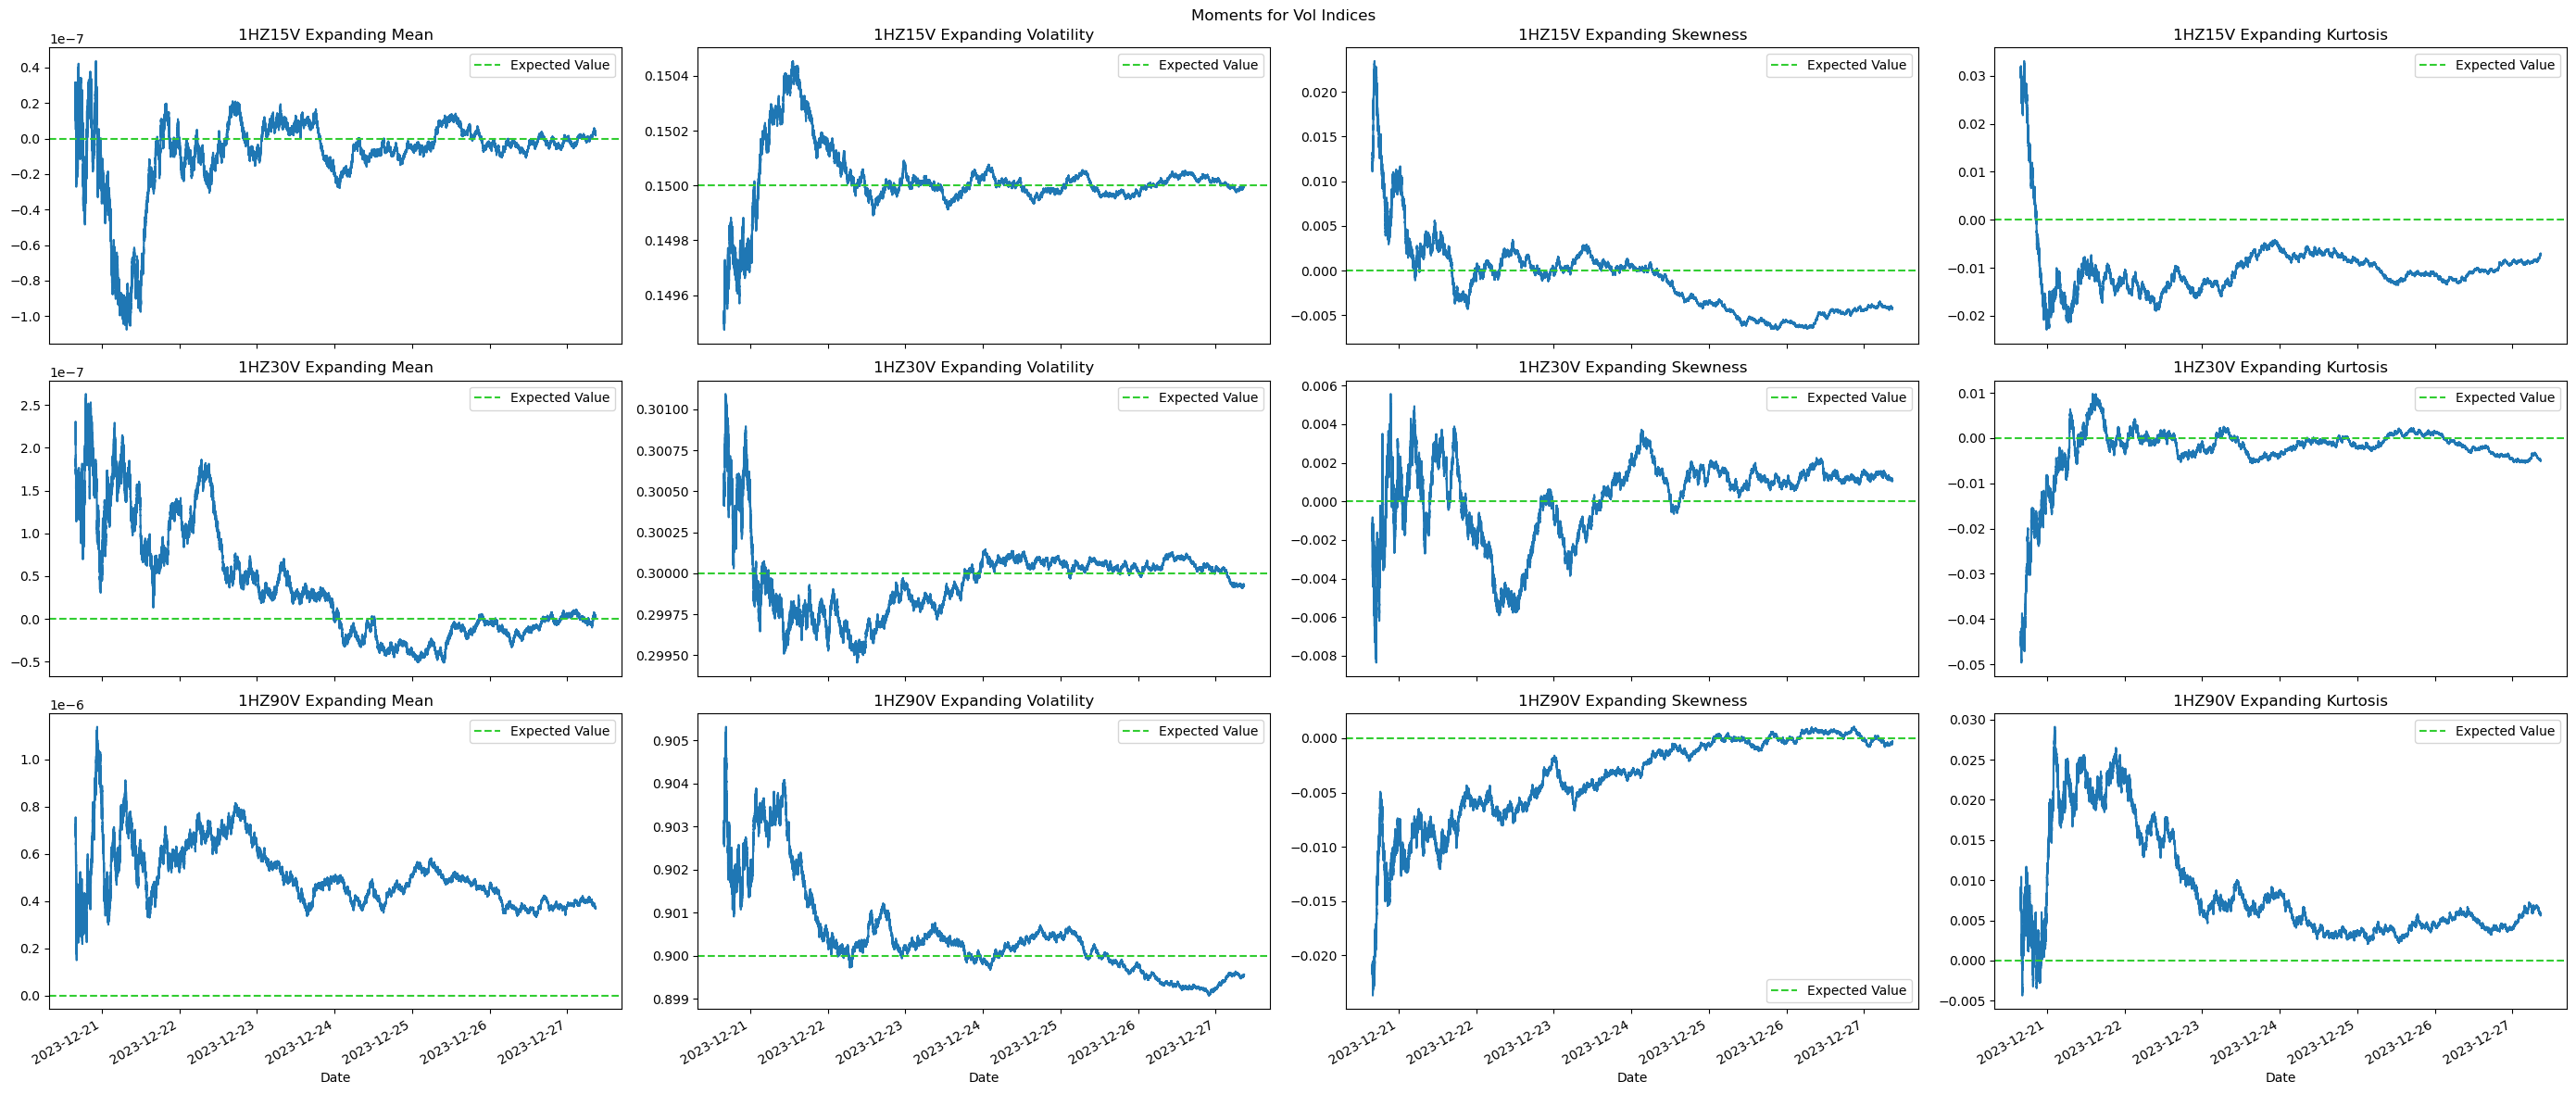

In [202]:
gap = 30_000

fig, ax = plt.subplots(3,4, figsize = (28,12))
for i, vol in enumerate(VOL):
    log_returns = vol_lr[vol]
    means = log_returns.expanding(gap).mean()
    vols = log_returns.expanding(gap).std() / np.sqrt(DT)
    skews = log_returns.expanding(gap).skew()
    kurts = log_returns.expanding(gap).kurt()

    # Plot Jump cumulative jump frequency
    ax[i,0].plot(means)
    ax[i,0].axhline(vol_expected.loc[vol, 'drift'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,0].set_title(f'{vol} Expanding Mean')
    ax[i,0].legend()

    ax[i,1].plot(vols)
    ax[i,1].axhline(vol_expected.loc[vol, 'vol'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,1].set_title(f'{vol} Expanding Volatility')
    ax[i,1].legend()

    ax[i,2].plot(skews)
    ax[i,2].axhline(vol_expected.loc[vol, 'skew'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,2].set_title(f'{vol} Expanding Skewness')
    ax[i,2].legend()

    ax[i,3].plot(kurts)
    ax[i,3].axhline(vol_expected.loc[vol, 'E. kurtosis'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,3].set_title(f'{vol} Expanding Kurtosis')
    ax[i,3].legend()

    
    for j in range(4):
        ax[i,j].set_xlabel('Date')
    fig.suptitle(
        f"Moments for CTrader Vol Indices"
    )
    fig.autofmt_xdate(rotation=30)

fig.suptitle("Moments for Vol Indices")
plt.tight_layout()
plt.show()

### 3. Log Return Distributions

We expect the distributions of log returns to look like a roughly centered normal distribution. Indeed, we see that is the case

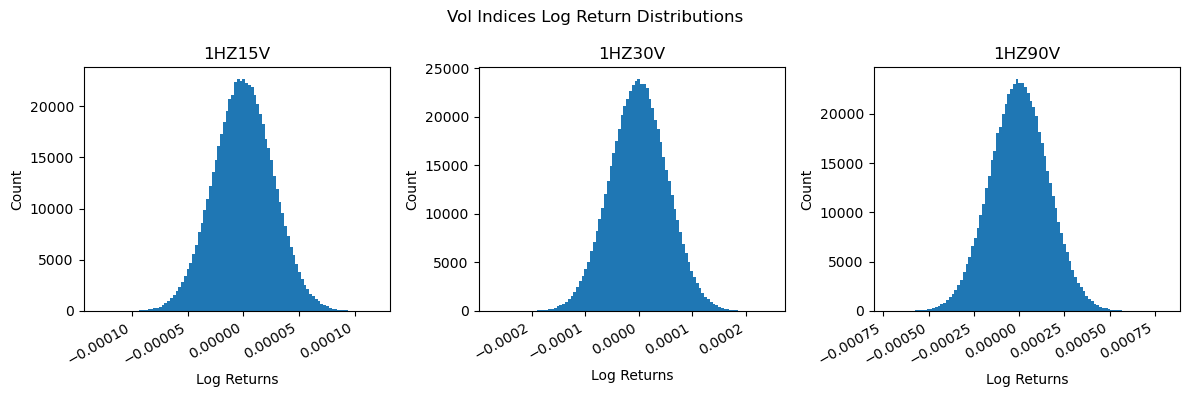

In [265]:
# for vol in VOL:
#     log_returns = vol_lr[vol]
#     plt.figure()
#     plt.hist(log_returns, bins=100)
#     plt.title(vol + ' - Log Return Distribution')

fig, ax = plt.subplots(1,3, figsize = (12,4))
flattened = ax.flatten()
for i, index in enumerate(VOL):
    log_returns = vol_lr[index]

    # Plot log return histogram
    flattened[i].hist(log_returns, bins=100)
    flattened[i].set_title(index)
    flattened[i].set_xlabel("Log Returns")
    flattened[i].set_ylabel('Count')
    flattened[i].set_title(
        f"{index}"
    )

fig.suptitle("Vol Indices Log Return Distributions")
fig.autofmt_xdate()
plt.tight_layout()
plt.show()

### 4. Spread Checks (Metabase)

We observe there was a difference between the expected spread percentage and the spread percentage of the Ctrader/Metabase Feed. There were multiple reasons this was occurring:

* The production code below ([Link](https://github.com/regentmarkets/perl-feed-index-volatility/blob/06355f5ec02c4add1b4c05f188785e3ec2fbdd31/lib/Feed/Index/Volatility/GBM.pm#L94-L99)) results in differences between the Metabase spread and the expected spreads as there is rounding off in the half-spreads:


```
my $spread = $spot * sqrt($volatility**2 * 2 / $_SECS_PER_YEAR) * $spread_multiplier;
my $y      = POSIX::floor(POSIX::log10($spread));
my $x      = $spread / (10**$y);
my $s      = max(2, round($x / 2) * 2);


$latest_value->{spread}          = $s * 10**$y;
```

* The half-spread of Ctrader is the Metabase half-spread + a markup of 0.01% of the spot price (the 0.01% markup is rounded off to 3 dp), added by the Dealing team. Note that it is a magnitude higher than the actual base spread as CTrader settings for percentage spread is limited to 0.01% at minimum. Refer to slack message [here](https://deriv-group.slack.com/archives/C05G8JW13JL/p1703242802762649).

The following values are from the Metabase feed, which is only affected by No 1.

In [266]:
# vol = 0.9
# spot = 10_000
# dt = 365*86400
# spread_multiplier = 1
# spread =  spot * np.sqrt(vol**2 * 2 / dt) * spread_multiplier
# y = np.floor(np.log10(spread))
# x = spread / (10**y);
# s = max(2, round(x / 2) * 2);
# final_spread = s * 10**y
# print("spread = {}".format(spread))
# print("y = {}".format(y))
# print("x = {}".format(x))
# print("s = {}".format(s))
# print("final_spread = {}".format(final_spread))

In [205]:
expected_spreads_vol = pd.DataFrame.from_dict(dict(zip(VOL, [0.00378, 0.00755, 0.0227])), orient='index', columns=['Expected Relative Spread (%)'])

for vol in VOL:
    expected_spreads_vol.loc[vol, 'Observed Mean Relative Spread (%)'] = ((asks_vol[vol] - bids_vol[vol]) / spots_vol[vol] * 100).mean()

display(expected_spreads_vol)   

,Expected Relative Spread (%),Observed Mean Relative Spread (%)
1HZ15V,0.00378,0.0040098042
1HZ30V,0.00755,0.0079900081
1HZ90V,0.02270,0.0174182164


## Crash/Boom Indices (600, 900)

### 1. Moments

There aren't any defined expected moments, so we would just like the drift to be as low as possible

In [206]:
CB_lr = dict(zip(CB, [0,0,0,0]))
CB_sr = dict(zip(CB, [0,0,0,0]))
bids_CB = dict(zip(CB, [0,0,0,0]))
asks_CB = dict(zip(CB, [0,0,0,0]))
spots_CB = dict(zip(CB, [0,0,0,0]))

for cb in CB:
    feed = CB_prod[cb]
    CB_lr[cb] = np.log(feed.spot/feed.spot.shift(1)).dropna()
    CB_sr[cb] = ((feed.spot - feed.spot.shift(1)) / feed.spot.shift(1)).dropna()
    bids_CB[cb] = feed.bid
    asks_CB[cb] = feed.ask
    spots_CB[cb] = feed.spot

In [207]:
cb_drift = dict(zip(CB, [0,0,0,0]))
cb_vol = dict(zip(CB, [0,0,0,0]))
cb_skew = dict(zip(CB, [0,0,0,0]))
cb_kurt = dict(zip(CB, [0,0,0,0]))

for cb in CB:
    log_returns = CB_lr[cb]
    cb_vol[cb] = np.std(log_returns) / np.sqrt(DT)
    cb_drift[cb] = np.mean(log_returns)
    cb_skew[cb] = skew(log_returns)
    cb_kurt[cb] = kurtosis(log_returns)

cb_dict = {'drift' : cb_drift,
            'vol' : cb_vol,
            'skew' : cb_skew,
            'E. kurtosis' : cb_kurt}
cb_df = pd.DataFrame.from_dict(cb_dict)
cb_df

,drift,vol,skew,E. kurtosis
CRASH600,0.0000000937,0.2699374526,-36.7113107779,1529.0721655398
CRASH900,0.0000000012,0.2266399688,-44.8474603616,2331.5825487707
BOOM600,0.0000000081,0.2816446211,36.2615120397,1489.4099570317
BOOM900,-0.0000000696,0.2191318674,46.0937410403,2458.8352900648


### 2. Convergence of Moments

We also see the rate of convergence of the moments. They tend to stabilize within 2-4 days (unless a particularly large jump occurs):

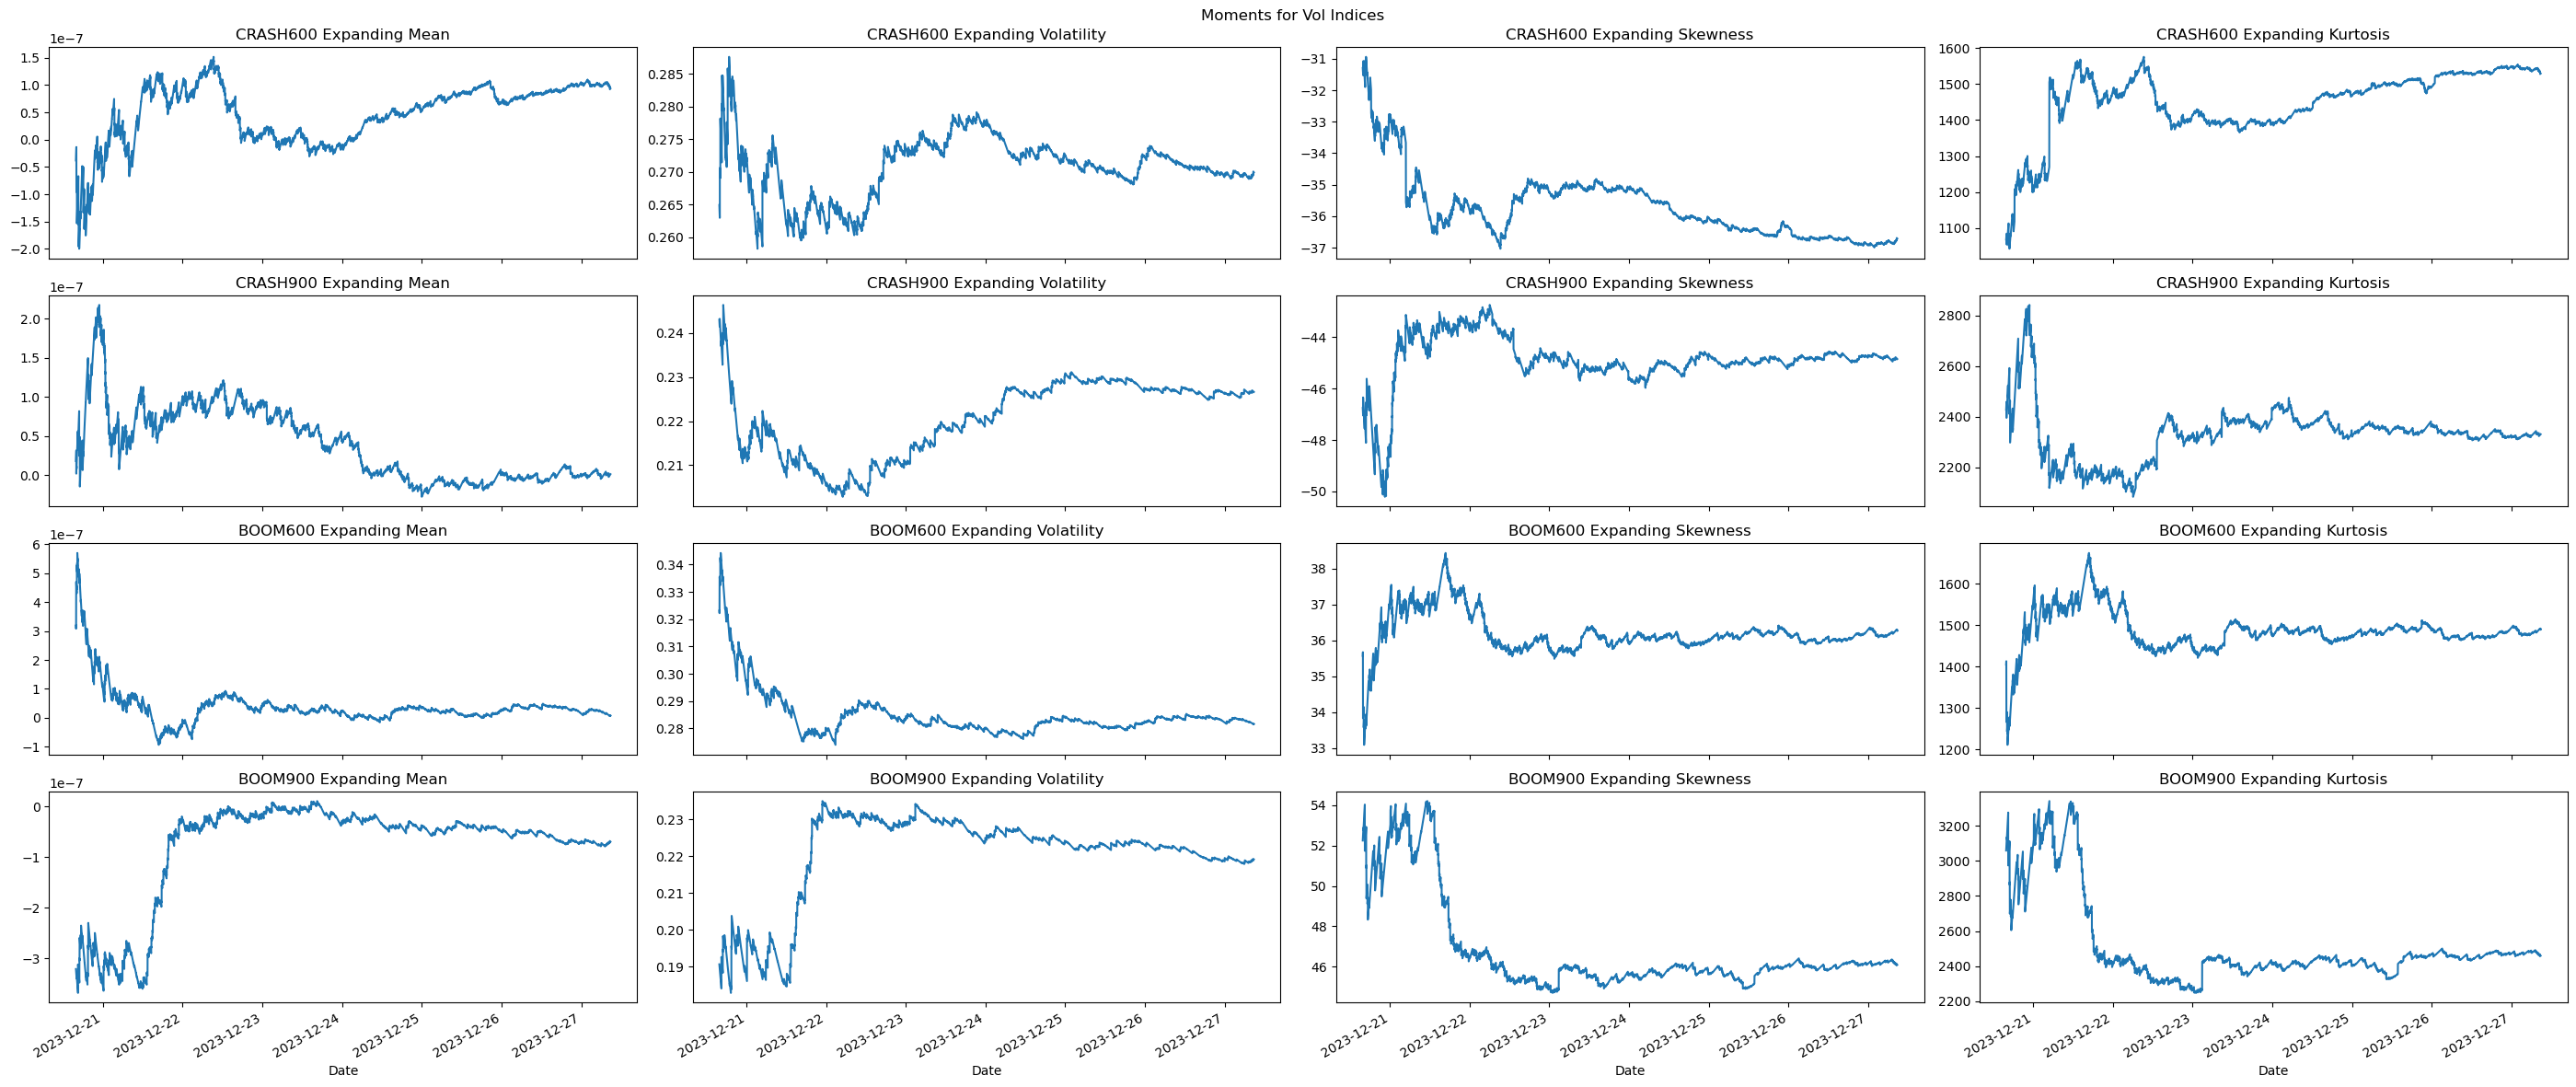

In [208]:
gap = 30_000

fig, ax = plt.subplots(4,4, figsize = (28,12))
for i, cb in enumerate(CB):
    log_returns = CB_lr[cb]
    means = log_returns.expanding(gap).mean()
    vols = log_returns.expanding(gap).std() / np.sqrt(DT)
    skews = log_returns.expanding(gap).skew()
    kurts = log_returns.expanding(gap).kurt()

    # Plot Jump cumulative jump frequency
    ax[i,0].plot(means)
    # ax[i,0].axhline(CB_expected.loc[cb, 'drift'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,0].set_title(f'{cb} Expanding Mean')
    # ax[i,0].legend()

    ax[i,1].plot(vols)
    # ax[i,1].axhline(CB_expected.loc[cb, 'vol'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,1].set_title(f'{cb} Expanding Volatility')
    # ax[i,1].legend()

    ax[i,2].plot(skews)
    # ax[i,2].axhline(CB_expected.loc[cb, 'skew'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,2].set_title(f'{cb} Expanding Skewness')
    # ax[i,2].legend()

    ax[i,3].plot(kurts)
    # ax[i,3].axhline(CB_expected.loc[cb, 'E. kurtosis'], color='limegreen', ls = '--', label='Expected Value')
    ax[i,3].set_title(f'{cb} Expanding Kurtosis')
    # ax[i,3].legend()

    
    for j in range(4):
        ax[i,j].set_xlabel('Date')
    fig.suptitle(
        f"Moments for CTrader Crash/Boom Indices"
    )
    fig.autofmt_xdate(rotation=30)

fig.suptitle("Moments for Vol Indices")
plt.tight_layout()
plt.show()

### 3. Step/Jump Distributions

The distributions of the steps/jumps should both look like folded normal distributions. There aren't enough points to get a full shape, but they resemble what we expect.

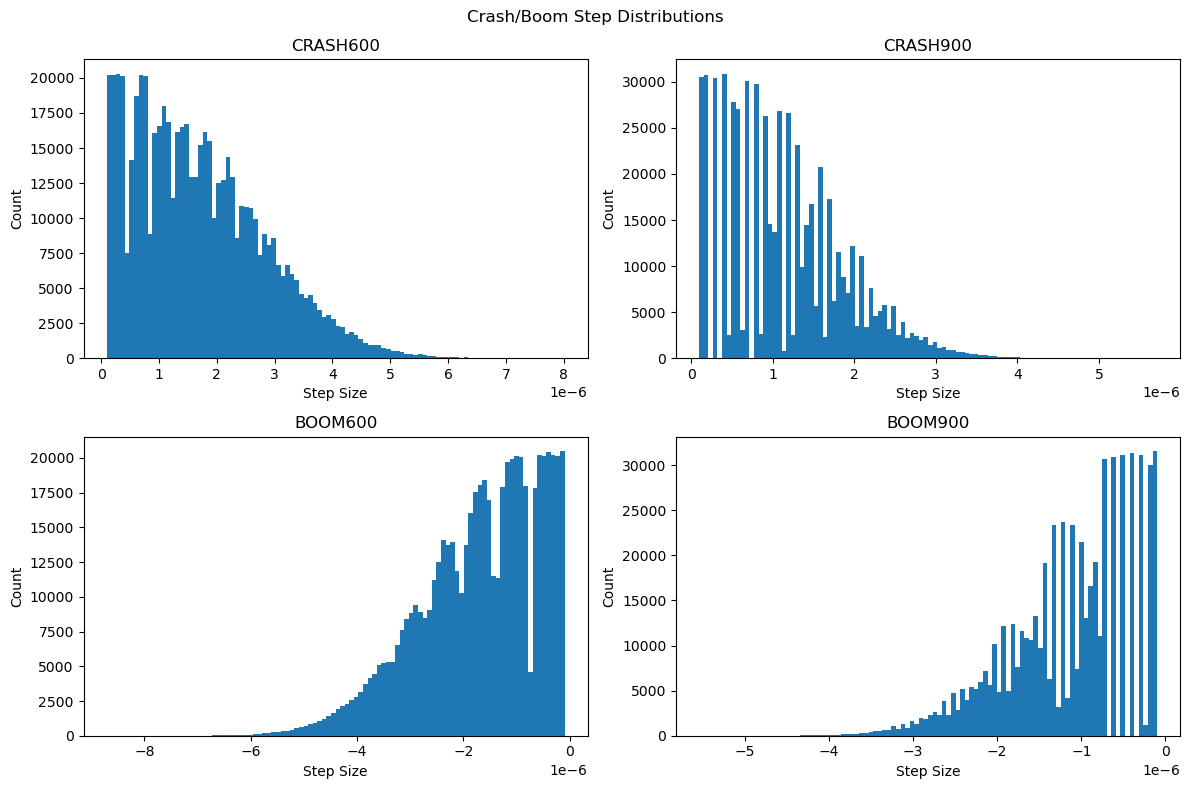

In [209]:
fig, ax = plt.subplots(2,2, figsize = (12,8))
flattened = ax.flatten()
for i, index in enumerate(CB):
    log_returns = CB_lr[index]
    step_indices = (log_returns < 0) if "BOOM" in index else (log_returns > 0)
    steps = log_returns[step_indices]
    
    # Plot Jump cumulative jump frequency
    flattened[i].hist(steps, bins=100)
    flattened[i].set_title(index)
    flattened[i].set_xlabel("Step Size")
    flattened[i].set_ylabel('Count')
    flattened[i].set_title(
        f"{index}"
    )

fig.suptitle("Crash/Boom Step Distributions")
plt.tight_layout()
plt.show()

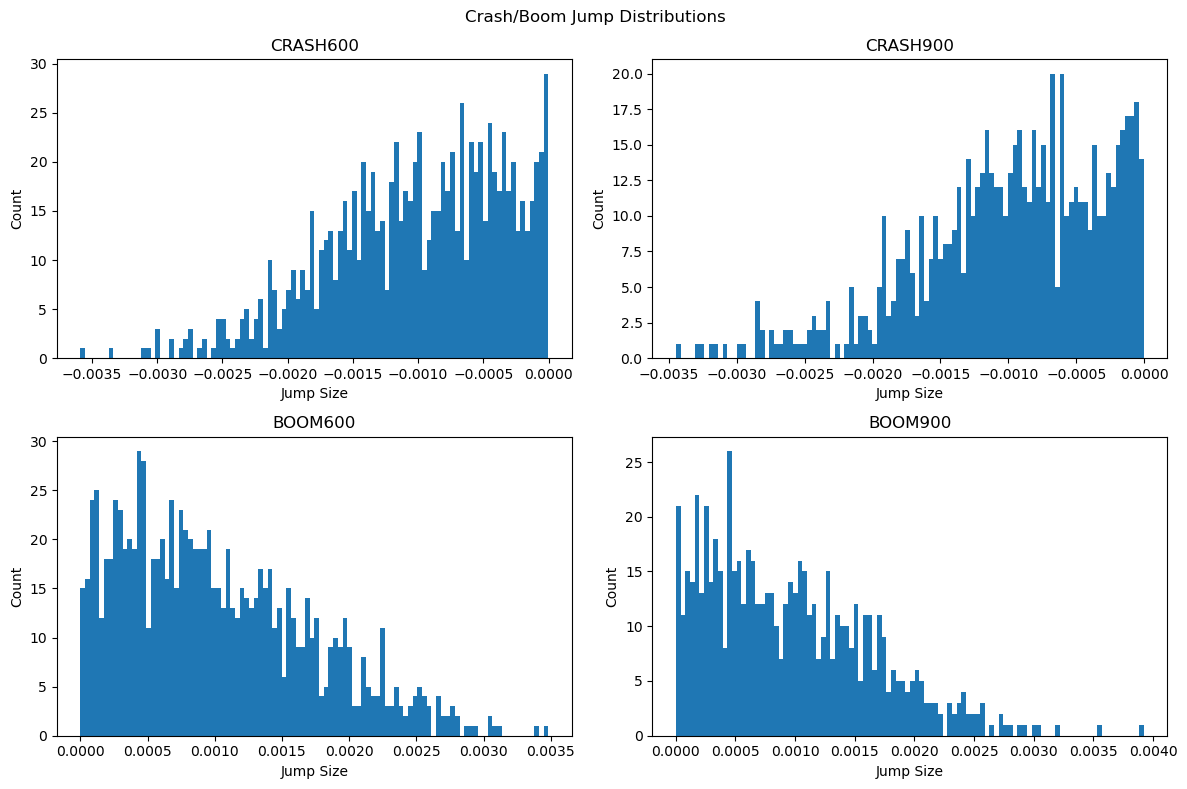

In [210]:
empirical_jump_factor_mean = dict(zip(CB, [0,0,0,0]))
theoretical_jump_factor_mean = dict(zip(CB, [0,0,0,0]))

fig, ax = plt.subplots(2,2, figsize = (12,8))
flattened = ax.flatten()
for i, index in enumerate(CB):
    log_returns = CB_lr[index]
    # np.random.seed(1)
    jump_dir = CB_expected.loc[index, 'MUT' if "BOOM" in index else 'MDT'] 
    theoretical_jump_factor_mean[index] = jump_dir
    jump_indices = (log_returns > 0) if "BOOM" in index else (log_returns < 0)
    jumps = log_returns[jump_indices]
    empirical_jump_factor_mean[index] = jumps.mean() / np.sqrt(DT)
    
    # Plot Jump cumulative jump frequency
    flattened[i].hist(jumps, bins=100)
    flattened[i].set_title(index)
    flattened[i].set_xlabel("Jump Size")
    flattened[i].set_ylabel('Count')
    flattened[i].set_title(
        f"{index}"
    )

fig.suptitle("Crash/Boom Jump Distributions")
plt.tight_layout()
plt.show()

# print(theoretical_jump_mean)


### Jump/Step Parameters

CB jump factors/probability should be within reasonable bounds of the expected parameters as shown below. The graphs that follow demonstrate the factors calculated over time, with thresholds indicating the range of values in a 1% uncertainty around the actual value. The parameters tend to converge within 2 days

In [211]:
CB_expected_with_probs = CB_expected.loc[:,['MDT', 'MUT']]
CB_expected_with_probs['Jump Probability'] = CB_expected_with_probs.index.map(lambda x : 1/int(re.findall(r'\d+', x)[0]))
display(CB_expected_with_probs)

,MDT,MUT,Jump Probability
CRASH600,-5.6190000000,0.0093737306,0.0016666667
CRASH900,-5.6190000000,0.0062456807,0.0011111111
BOOM600,-0.0093875464,5.6190000000,0.0016666667
BOOM900,-0.0062548810,5.6190000000,0.0011111111


#### Jump Factor (MDT/MUT)

,MUT,Empirical Jump Factor,Empirical Jump Size (%)
CRASH600,-5.619,-5.6693061274,-0.1008807143
CRASH900,-5.619,-5.5149995836,-0.0981350435
BOOM600,5.619,5.6918527303,0.1014320018
BOOM900,5.619,5.4126214319,0.0964541120


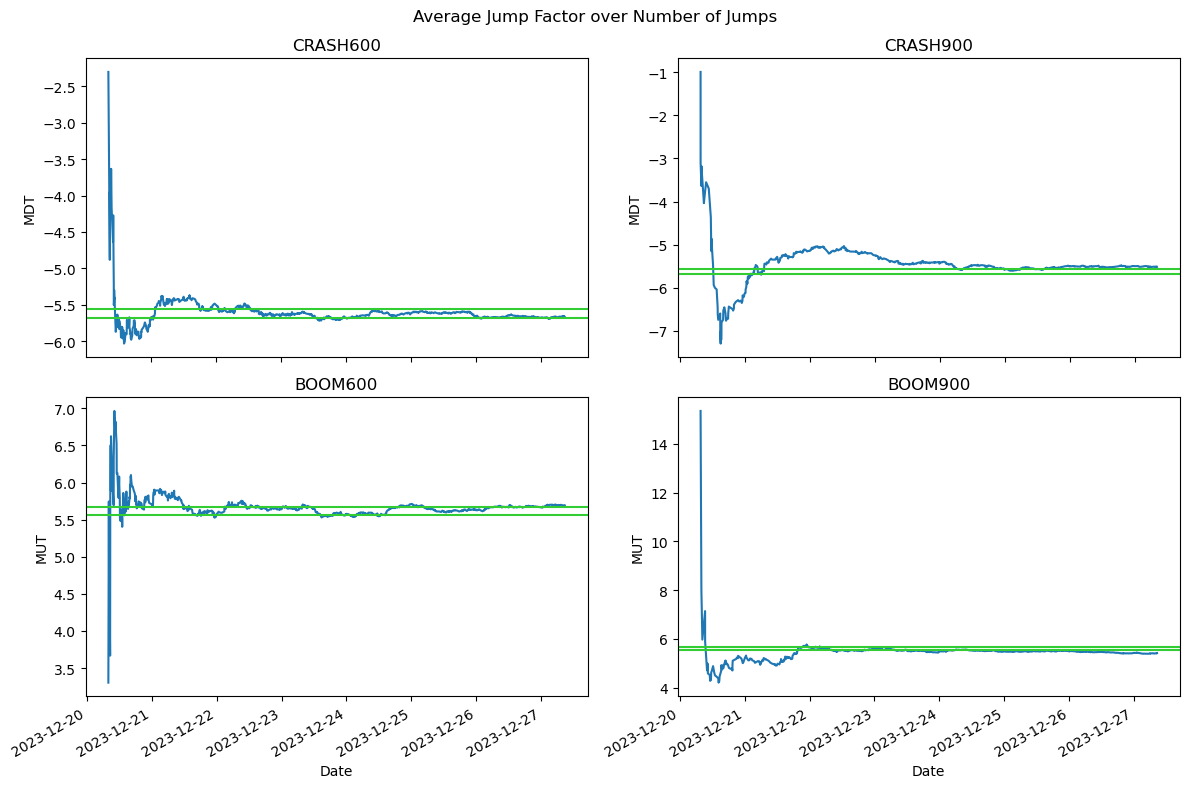

In [212]:
jump_factors = pd.DataFrame(CB_expected['MUT'].where(CB_expected.index.str.contains('BOOM'), CB_expected['MDT']))

fig, ax = plt.subplots(2,2, figsize = (12,8))
flattened = ax.flatten()
for i, index in enumerate(CB):
    boom = 'BOOM' in index
    jump_prob = 1/int(re.findall(r'\d+', index)[0])

    log_returns = CB_lr[index]
    jump_indices = (log_returns > 0) if boom else (log_returns < 0)
    jumps = log_returns[jump_indices]
    relative_jump_sizes = CB_sr[index][jump_indices]
    relative_jump_size_mean = relative_jump_sizes.mean() * 100
    jump_factor_cumulative_dist = jumps.cumsum() / (jumps == jumps).cumsum()
    jump_factors.loc[index, 'Empirical Jump Factor'] = jump_factor_cumulative_dist[-1] / np.sqrt(DT)
    jump_factors.loc[index, 'Empirical Jump Size (%)'] = relative_jump_size_mean

    # Plot Jump cumulative jump frequency
    flattened[i].plot(jump_factor_cumulative_dist / np.sqrt(DT))
    flattened[i].axhline(theoretical_jump_factor_mean[index]*(1.01), color='limegreen')
    flattened[i].axhline(theoretical_jump_factor_mean[index]*(0.99), color='limegreen')
    # plt.legend(np.round(sigma, 2))
    flattened[i].set_xlabel("Date")
    flattened[i].set_ylabel('MUT' if boom else 'MDT')
    flattened[i].set_title(
        f"{index}"
    )

display(jump_factors)
fig.autofmt_xdate(rotation=30)
fig.suptitle("Average Jump Factor over Number of Jumps")
plt.tight_layout()
plt.show()

#### Jump Probabilities

,Jump Probability,Empirical Jump Probability
CRASH600,0.0016666667,0.0015575199
CRASH900,0.0011111111,0.0011307836
BOOM600,0.0016666667,0.0016576073
BOOM900,0.0011111111,0.0010831889


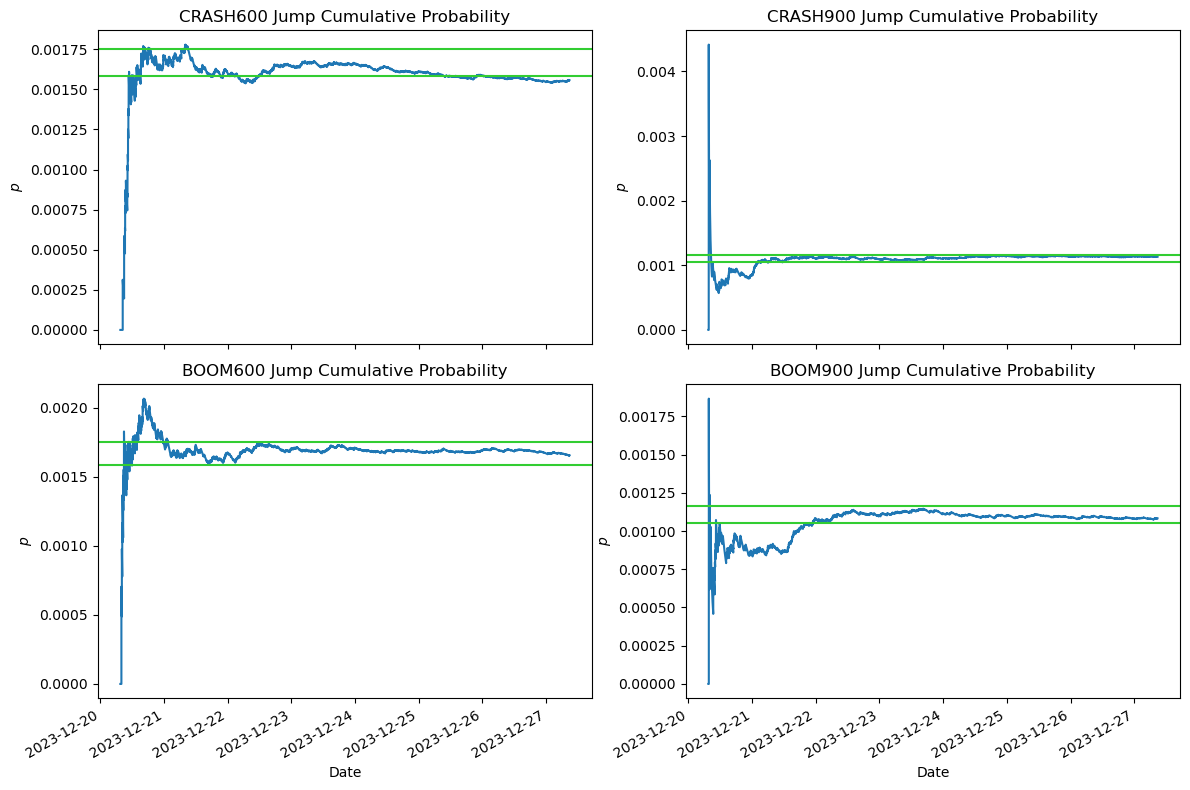

In [213]:
jump_probabilities = pd.DataFrame.from_dict(dict(zip(CB, list(map(lambda x : 1/int(re.findall(r'\d+', x)[0]), CB)))), orient='index', columns=['Jump Probability'])

fig, ax = plt.subplots(2,2, figsize = (12,8))
flattened = ax.flatten()
for i, index in enumerate(CB):
    boom = 'BOOM' in index
    jump_prob = 1/int(re.findall(r'\d+', index)[0])

    log_returns = CB_lr[index]
    jump_indices = (log_returns > 0) if boom else (log_returns < 0)
    jumps = log_returns[jump_indices]
    steps = log_returns[~jump_indices]

    jump_cumulative_dist = jump_indices.cumsum() / (log_returns == log_returns).cumsum()
    jump_probabilities.loc[index, 'Empirical Jump Probability'] = len(jumps)/(len(jumps) + len(steps))

    # Plot Jump cumulative jump frequency
    flattened[i].plot(jump_cumulative_dist)
    flattened[i].axhline(jump_prob*(1.05), color='limegreen')
    flattened[i].axhline(jump_prob*(0.95), color='limegreen')
    # plt.legend(np.round(sigma, 2))
    flattened[i].set_xlabel("Date")
    flattened[i].set_ylabel("$p$")
    flattened[i].set_title(
        f"{index} Jump Cumulative Probability"
    )

display(jump_probabilities)
fig.autofmt_xdate(rotation=30)
plt.tight_layout()
plt.show()

### 4. Spread Checks (Metabase)

We observe there was a difference between the expected spread percentage and the spread percentage of the Ctrader Feed. Metabase Feed spread does match the expected spread. The reason for the difference for the CTrader Feed is as follows

* The Metabase feed only considers the expected relative spread below, as a BE parameter. This is as expected.
* The half-spread of Ctrader is the Metabase half-spread + a markup of 0.01% of the spot price (the 0.01% markup is rounded off to 3 dp), added by the Dealing team. Note that it is a magnitude higher than the actual base spread as CTrader settings for percentage spread is limited to 0.01% at minimum. Refer to slack message [here](https://deriv-group.slack.com/archives/C05G8JW13JL/p1703242802762649).

The following values are from the Metabase feed, which match the expected spread.

In [214]:
expected_spreads_CB = pd.DataFrame.from_dict(dict(zip(CB, [0.00134, 0.00111, 0.00134, 0.00111])), orient='index', columns=['Expected Relative Spread (%)'])

for cb in CB:
    expected_spreads_CB.loc[cb, 'Observed Mean Relative Spread (%)'] = ((asks_CB[cb] - bids_CB[cb]) / spots_CB[cb] * 100).mean()

display(expected_spreads_CB)

,Expected Relative Spread (%),Observed Mean Relative Spread (%)
CRASH600,0.00134,0.0013399965
CRASH900,0.00111,0.0011100084
BOOM600,0.00134,0.0013399949
BOOM900,0.00111,0.0011099929


In [ ]:
CT_bid = 10113.779
CT_ask = 10115.913
MB_bid = 10114.790
MB_ask = 10114.902

spot = (CT_ask + CT_bid) / 2
print(f'{spot = }')
print('1% of spot:', 0.01/100*spot)
print('Difference between Ctrader and Metabase half-spreads (no rounding):', (((CT_ask - CT_bid) - (MB_ask-MB_bid))/2) / spot * 100)
print('CT_ask from Metabase half-spread added to rounded 1% of spot (no rounding)  :',spot + (spot * 0.01 / 100)         + (MB_ask-MB_bid)/2)
print('CT_ask from Metabase half-spread added to rounded 1% of spot (with rounding):',spot + round(spot * 0.01 / 100, 3) + (MB_ask-MB_bid)/2)

### 5. Negative Balance Simulation

Results given in the [spreadsheet](https://docs.google.com/spreadsheets/d/1-gxkTGlqNKW88oW99IPfVFkwuh_qqO4mAiAswqAPNIs/edit#gid=1566469484) (thanks, Matthew).

In short, a leverage of 1:400 (similar to existing CB indices) results in a Negative Balance Adjustment per Total Trades rate between 0.004% to 0.0045%.

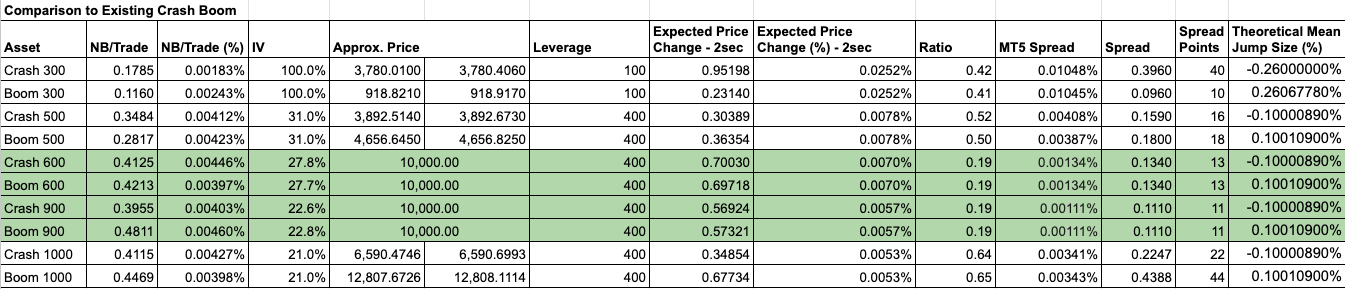

In [215]:
from IPython.display import Image
display(Image(filename="./CB600-900 Negative Balance Test.png", width=800))

## Spread check based on 8th Jan 2024 feed data
Spread for crash/boom indices match spreads proposed [here](https://docs.google.com/presentation/d/1VRl8sAHVoA4HT9rRuYy3jvJTpy6CD_YyiEJ0r-N6KOg/edit?usp=sharing). However do not match exactly for vol indices, notably 1HZ90V as the observed spread is significantly lower than proposed spreads. 

The discrepency is likely due to the operation performed by backend [here](https://github.com/regentmarkets/perl-feed-index-volatility/blob/06355f5ec02c4add1b4c05f188785e3ec2fbdd31/lib/Feed/Index/Volatility/GBM.pm#L94-L99).

In [33]:
expected_spreads_CB = pd.DataFrame.from_dict(dict(zip(CB, [0.00134, 0.00111, 0.00134, 0.00111])), orient='index', columns=['Expected Relative Spread (%)'])
expected_spreads_VOL = pd.DataFrame.from_dict(dict(zip(VOL, [0.00378, 0.00755, 0.0227])), orient='index', columns=['Expected Relative Spread (%)'])

for cb in CB:
    expected_spreads_CB.loc[cb, 'Observed Mean Relative Spread (%)'] = ((asks_CB[cb] - bids_CB[cb]) / spots_CB[cb] * 100).mean()

for vol in VOL:
    expected_spreads_VOL.loc[vol, 'Observed Mean Relative Spread (%)'] = ((asks_VOL[vol] - bids_VOL[vol])/ spots_VOL[vol]*100 ).mean()


display(expected_spreads_CB)
display(expected_spreads_VOL)   

,Expected Relative Spread (%),Observed Mean Relative Spread (%)
CRASH600,0.00134,0.00134
CRASH900,0.00111,0.00111
BOOM600,0.00134,0.00134
BOOM900,0.00111,0.00111


,Expected Relative Spread (%),Observed Mean Relative Spread (%)
1HZ15V,0.00378,0.003949
1HZ30V,0.00755,0.008307
1HZ90V,0.02270,0.016347


## Verifying volatility of new indices based on CTrader feed 
Data used was from 4th Jan 2024 to 9th Jan 2024. Volatility of new indices are in reasonable range.

To note, around 1 % to 1.8 % of Crash/Boom indices feed data contains NANs while Volatility indices do not have that issue.

In [2]:
CB = ['CRASH600', 'CRASH900','BOOM600', 'BOOM900']
VOL = ['1HZ15V', '1HZ30V', '1HZ90V']
# crash300_prod = pd.read_csv('data/crash300.csv')
crash600_prod = pd.read_csv('c600.csv')
crash900_prod = pd.read_csv('c900.csv')
# boom300_prod = pd.read_csv('data/boom300.csv')
boom600_prod = pd.read_csv('b600.csv')
boom900_prod = pd.read_csv('b900.csv')
vol15_prod = pd.read_csv('v15.csv')
vol30_prod = pd.read_csv('v30.csv')
vol90_prod = pd.read_csv('v90.csv')
CB_prod = dict(zip(CB, [crash600_prod, crash900_prod, boom600_prod, boom900_prod]))
VOL_prod = dict(zip(VOL, [vol15_prod, vol30_prod, vol90_prod]))
for cb in CB:
    df = CB_prod[cb].copy()
    print('Percentage NANs in',cb,'data:',len(df[pd.isna(df).any(axis=1)])/len(df)*100,'%')
    df = df.sort_values('DateTime')
    df.set_index('DateTime', inplace=True)
    df = df.fillna(method='ffill')
    df['spot'] = (df.BID+df.ASK)/2
    df['lr']=np.log(df.spot/df.spot.shift())
    df.drop(df.index[0], axis=0, inplace=True)
    CB_prod[cb] = df
for vol in VOL:
    df = VOL_prod[vol].copy()
    print('Percentage NANs in',vol,'data:',len(df[pd.isna(df).any(axis=1)])/len(df)*100,'%')
    df = df.sort_values('DateTime')
    df.set_index('DateTime', inplace=True)
    df = df.fillna(method='ffill')
    df['spot'] = (df.BID+df.ASK)/2
    df['lr']=np.log(df.spot/df.spot.shift())
    df.drop(df.index[0], axis=0, inplace=True)
    VOL_prod[vol] = df 
expected_vols_CB = pd.DataFrame.from_dict(dict(zip(CB, [27.234934, 22.15459814, 27.59856988, 22.35227095])), orient='index', columns=['Expected Vol (%)'])
expected_vols_VOL = pd.DataFrame.from_dict(dict(zip(VOL, [15, 30, 90])), orient='index', columns=['Expected Vol (%)'])
for cb in CB:
    vol90_prod['s']=(vol90_prod.BID+vol90_prod.ASK)/2
    expected_vols_CB.loc[cb, 'Observed Vol (%)'] = CB_prod[cb].lr.std()*np.sqrt(365*86400)*100
for vol in VOL:
    expected_vols_VOL.loc[vol, 'Observed Vol (%)'] = VOL_prod[vol].lr.std()*np.sqrt(365*86400)*100
display(expected_vols_CB)
display(expected_vols_VOL)   

Percentage NANs in CRASH600 data: 1.0386312016571067 %
Percentage NANs in CRASH900 data: 1.6714982900197541 %
Percentage NANs in BOOM600 data: 1.0538825393588065 %
Percentage NANs in BOOM900 data: 1.8530077549391812 %
Percentage NANs in 1HZ15V data: 0.0 %
Percentage NANs in 1HZ30V data: 0.0 %
Percentage NANs in 1HZ90V data: 0.0 %


,Expected Vol (%),Observed Vol (%)
CRASH600,27.234934,26.608723
CRASH900,22.154598,22.253074
BOOM600,27.598570,27.908112
BOOM900,22.352271,23.253534


,Expected Vol (%),Observed Vol (%)
1HZ15V,15,15.051919
1HZ30V,30,30.144464
1HZ90V,90,90.368265


In [8]:
expected_spreads_CB = pd.DataFrame.from_dict(dict(zip(CB, [0.00134, 0.00111, 0.00134, 0.00111])), orient='index', columns=['Expected Relative Spread (%)'])
expected_spreads_VOL = pd.DataFrame.from_dict(dict(zip(VOL, [0.00378, 0.00755, 0.0227])), orient='index', columns=['Expected Relative Spread (%)'])

for cb in CB:
    expected_spreads_CB.loc[cb, 'Observed Mean Relative Spread (%)'] = ((CB_prod[cb].ASK - CB_prod[cb].BID) / CB_prod[cb].spot * 100).mean()

for vol in VOL:
    expected_spreads_VOL.loc[vol, 'Observed Mean Relative Spread (%)'] = ((VOL_prod[vol].ASK - VOL_prod[vol].BID)/VOL_prod[vol].spot*100 ).mean()


display(expected_spreads_CB)
display(expected_spreads_VOL)   

,Expected Relative Spread (%),Observed Mean Relative Spread (%)
CRASH600,0.00134,0.00134
CRASH900,0.00111,0.00111
BOOM600,0.00134,0.00134
BOOM900,0.00111,0.00111


,Expected Relative Spread (%),Observed Mean Relative Spread (%)
1HZ15V,0.00378,0.003943
1HZ30V,0.00755,0.008301
1HZ90V,0.02270,0.017418


R&D effort needs to be in line with Deriv’s vision and mission as formulated by our CEO. Therefore all R&D projects are carefully selected by our C-Level senior management represented by JY and Rakshit and resources for the projects are only allocated after review and shortlisting based on their vision and priorities. 

In line with the standards and criterias set out by the CEO, the Model Validation team has validated the product/indices as documented in this report.